In [216]:
import pandas as pd
import numpy as np
from jupyterthemes import jtplot

jtplot.style()

import statsmodels.api as sm

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [198]:
df = pd.read_csv('./../data/Monsteruitslagen_Resultaten.csv')
df['datetime'] = pd.to_datetime(df.datum + ' ' + df.tijd)

def convert_tappunt(x):
    x = str(x).lower()
    if 'thermostatische douchemengkraan' in x or 'therm.' in x:
        return 'Thermostatische douchemengkraan'
    if 'douche' in x:
        return 'douche'
    if '1e tappunt' in x:
        return '1e tappunt'
    return 'overige'

def convert_ruimte(x):
    x = str(x).lower()
    if 'kelder' in x:
        return 'kelder'
    if 'kamer' in x:
        return 'kamer'
    if 'appartement' in x:
        return 'appartement'
    if 'technische ruimte' in x:
        return 'technische ruimte'
    if 'kapsalon' in x:
        return 'kapsalon'
    return 'overige'
    
df['tappunt_simple'] = df.tappunt.apply(convert_tappunt)
df['ruimte_simple'] = df.ruimte.apply(convert_ruimte)
df['location_is_Noorderkroon'] = df.locatienaam.str.contains('Noorderkroon')

df_tmp = df[df.component == 'Totaal Legionella spp'].copy()
df_tmp.resultaat = df_tmp.resultaat.str.replace('<100', '0').astype(int)
df_tmp.resultaat.groupby(pd.qcut(df_tmp.tempvoor, 4)).describe()

def get_level(x):
    for i in [0,1,2,3,4]:
        if '{}.'.format(i) in x:
            return i
    return -1
    
df_tmp['app_level'] = df_tmp.ruimte.apply(get_level)

In [215]:
df.component.unique()

array(['Koloniegetal 22 °C', 'Koper (ICP-MS)', 'Totaal Legionella spp',
       'Zilver (ICP-MS)', 'Legionella non-pneumophila',
       'Legionella pneumophila', 'Bacteriën van de coligroep',
       'Calcium (ICP-MS)', 'EGV 20°C', 'Enterokokken spp',
       'Escherichia coli (standaard test)', 'Intestinale enterokokken',
       'Magnesium (ICP-MS)', 'Stoorflora', 'Temperatuur tijdens meting',
       'Totale hardheid berekend', 'Waterstofcarbonaat', 'Zuurgraad',
       'Geanalyseerd volume'], dtype=object)

In [34]:
(df_tmp.resultaat > 0).astype(int).groupby(df_tmp.analyzepakket).describe()

,count,mean,std,min,25%,50%,75%,max
analyzepakket,,,,,,,,
HDSC_11,147.0,0.278912,0.449997,0.0,0.0,0.0,1.0,1.0
HDSC_3D_KZ,314.0,0.324841,0.469063,0.0,0.0,0.0,1.0,1.0


In [50]:
(df_tmp.resultaat > 0).astype(int).groupby(df_tmp.datetime.dt.hour).describe()

,count,mean,std,min,25%,50%,75%,max
datetime,,,,,,,,
8,1.0,0.000000,NaN,0.0,0.0,0.0,0.00,0.0
9,14.0,0.142857,0.363137,0.0,0.0,0.0,0.00,1.0
10,60.0,0.416667,0.497167,0.0,0.0,0.0,1.00,1.0
11,82.0,0.451220,0.500677,0.0,0.0,0.0,1.00,1.0
12,91.0,0.285714,0.454257,0.0,0.0,0.0,1.00,1.0
13,98.0,0.234694,0.425986,0.0,0.0,0.0,0.00,1.0
14,94.0,0.265957,0.444211,0.0,0.0,0.0,1.00,1.0
15,20.0,0.250000,0.444262,0.0,0.0,0.0,0.25,1.0
16,1.0,0.000000,NaN,0.0,0.0,0.0,0.00,0.0


In [241]:
model = sm.Logit(df_tmp.resultaat > 0,
                 pd.get_dummies(df_tmp.datetime.dt.hour))
model.fit().summary()

         Current function value: 0.599724
         Iterations: 35


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              resultaat   No. Observations:                  461
Model:                          Logit   Df Residuals:                      452
Method:                           MLE   Df Model:                            8
Date:                Fri, 01 Nov 2019   Pseudo R-squ.:                 0.03154
Time:                        21:45:50   Log-Likelihood:                -276.47
converged:                      False   LL-Null:                       -285.48
                                        LLR p-value:                   0.02116
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
8            -19.3286   1.57e+04     -0.001      0.999   -3.09e+04    3.08e+04
9             -1.7918      0.764     -2.346      0.019      -3.289      -0.295
10            -0.3365      0.262     -1.285      0.199      -0.850       0.177
11            -0.1957      0.222     -0.882      0.378      -0.631       0.239
12            -0.9163      0.232     -3.949      0.000      -1.371      -0.461
13            -1.1820      0.238     -4.959      0.000      -1.649      -0.715
14            -1.0152      0.233     -4.349      0.000      -1.473      -0.558
15            -1.0986      0.516     -2.127      0.033      -2.111      -0.086
16           -19.3286   1.57e+04     -0.001      0.999   -3.09e+04    3.08e+04
==============================================================================
"""

In [202]:
(df_tmp.resultaat > 0).astype(int).groupby(df_tmp.datetime.dt.dayofweek).describe()

,count,mean,std,min,25%,50%,75%,max
datetime,,,,,,,,
0,149.0,0.268456,0.444651,0.0,0.0,0.0,1.00,1.0
1,9.0,0.444444,0.527046,0.0,0.0,0.0,1.00,1.0
2,163.0,0.361963,0.482049,0.0,0.0,0.0,1.00,1.0
3,60.0,0.250000,0.436667,0.0,0.0,0.0,0.25,1.0
4,80.0,0.312500,0.466437,0.0,0.0,0.0,1.00,1.0


In [231]:
model = sm.Logit(df_tmp.resultaat > 0,
                 pd.get_dummies(df_tmp.datetime.dt.dayofweek))
model.fit().summary()

Optimization terminated successfully.
         Current function value: 0.613830
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              resultaat   No. Observations:                  461
Model:                          Logit   Df Residuals:                      456
Method:                           MLE   Df Model:                            4
Date:                Fri, 01 Nov 2019   Pseudo R-squ.:                0.008764
Time:                        21:39:16   Log-Likelihood:                -282.98
converged:                       True   LL-Null:                       -285.48
                                        LLR p-value:                    0.2869
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.0025      0.185     -5.423      0.000      -1.365      -0.640
1             -0.2231      0.671     -0.333      0.739      -1.538       1.092
2             -0.5669      0.163     -3.478      0.001      -0.886      -0.247
3             -1.0986      0.298     -3.685      0.000      -1.683      -0.514
4             -0.7885      0.241     -3.269      0.001      -1.261      -0.316
==============================================================================
"""

In [133]:
(df_tmp.resultaat > 0).astype(int).groupby(df_tmp['ruimte_simple']).describe()

,count,mean,std,min,25%,50%,75%,max
ruimte_simple,,,,,,,,
appartement,157.0,0.471338,0.500775,0.0,0.0,0.0,1.0,1.0
kamer,211.0,0.322275,0.468459,0.0,0.0,0.0,1.0,1.0
kapsalon,7.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
kelder,77.0,0.012987,0.113961,0.0,0.0,0.0,0.0,1.0
overige,9.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [165]:
(df_tmp.resultaat > 0).astype(int).groupby(df_tmp['location_is_Noorderkroon']).describe()

,count,mean,std,min,25%,50%,75%,max
location_is_Noorderkroon,,,,,,,,
False,219.0,0.178082,0.383458,0.0,0.0,0.0,0.0,1.0
True,242.0,0.429752,0.496067,0.0,0.0,0.0,1.0,1.0


In [201]:
(df_tmp.resultaat > 0).astype(int).groupby(df_tmp['app_level']).describe()

,count,mean,std,min,25%,50%,75%,max
app_level,,,,,,,,
-1,261.0,0.325670,0.469525,0.0,0.0,0.0,1.0,1.0
0,27.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,50.0,0.380000,0.490314,0.0,0.0,0.0,1.0,1.0
2,72.0,0.305556,0.463875,0.0,0.0,0.0,1.0,1.0
3,51.0,0.333333,0.476095,0.0,0.0,0.0,1.0,1.0


In [230]:
df_app_level = df_tmp[df_tmp.app_level != -1]
model = sm.Logit(df_app_level.resultaat > 0, 
                 pd.get_dummies(df_app_level['app_level'], prefix='app_level'))
model.fit().summary()

         Current function value: 0.549907
         Iterations: 35


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              resultaat   No. Observations:                  200
Model:                          Logit   Df Residuals:                      196
Method:                           MLE   Df Model:                            3
Date:                Fri, 01 Nov 2019   Pseudo R-squ.:                 0.08676
Time:                        21:38:15   Log-Likelihood:                -109.98
converged:                      False   LL-Null:                       -120.43
                                        LLR p-value:                 0.0001105
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
app_level_0   -30.8910   9.82e+05  -3.14e-05      1.000   -1.93e+06    1.93e+06
app_level_1    -0.4895      0.291     -1.680      0.093      -1.061       0.082
app_level_2    -0.8210      0.256     -3.209      0.001      -1.322      -0.320
app_level_3    -0.6931      0.297     -2.333      0.020      -1.275      -0.111
===============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [59]:
(df_tmp.resultaat > 0).astype(int).groupby(df_tmp.tappunt_simple).describe().sort_values('count')

,count,mean,std,min,25%,50%,75%,max
tappunt_simple,,,,,,,,
overige,4.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1e tappunt,74.0,0.013514,0.116248,0.0,0.0,0.0,0.0,1.0
Thermostatische douchemengkraan,127.0,0.401575,0.492158,0.0,0.0,0.0,1.0,1.0
douche,256.0,0.355469,0.479593,0.0,0.0,0.0,1.0,1.0


In [233]:
model = sm.Logit(df_tmp.resultaat > 0, 
                 pd.get_dummies(df_tmp['tappunt_simple'], prefix='tappunt_simple'))
model.fit().summary()

         Current function value: 0.558452
         Iterations: 35


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              resultaat   No. Observations:                  461
Model:                          Logit   Df Residuals:                      457
Method:                           MLE   Df Model:                            3
Date:                Fri, 01 Nov 2019   Pseudo R-squ.:                 0.09819
Time:                        21:39:56   Log-Likelihood:                -257.45
converged:                      False   LL-Null:                       -285.48
                                        LLR p-value:                 4.075e-12
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
tappunt_simple_1e tappunt                         -4.2905      1.007     -4.261      0.000      -6.264      -2.317
tappunt_simple_Thermostatische douchemengkraan    -0.3989      0.181     -2.204      0.028      -0.754      -0.044
tappunt_simple_douche                             -0.5951      0.131     -4.557      0.000      -0.851      -0.339
tappunt_simple_overige                           -20.9111   1.74e+04     -0.001      0.999   -3.41e+04     3.4e+04
==================================================================================================================
"""

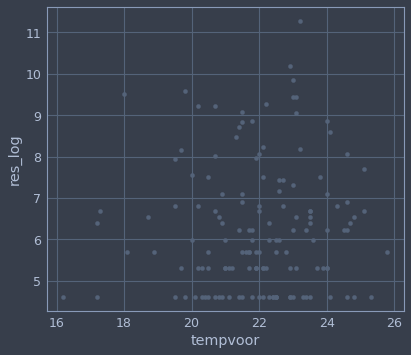

In [212]:
df_tmp.plot.scatter('tempvoor', 'res_log')


In [240]:
model = sm.Logit(df_tmp.resultaat > 0, 
                 pd.get_dummies(df_tmp[['tempvoor']], prefix='tappunt_simple'))
model.fit().summary()

Optimization terminated successfully.
         Current function value: 0.630180
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              resultaat   No. Observations:                  461
Model:                          Logit   Df Residuals:                      460
Method:                           MLE   Df Model:                            0
Date:                Fri, 01 Nov 2019   Pseudo R-squ.:                -0.01764
Time:                        21:44:26   Log-Likelihood:                -290.51
converged:                       True   LL-Null:                       -285.48
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tempvoor      -0.0345      0.005     -7.358      0.000      -0.044      -0.025
==============================================================================
"""

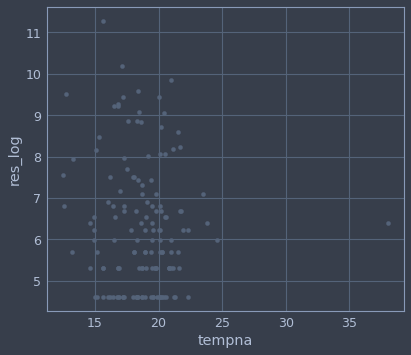

In [213]:
df_tmp.plot.scatter('tempna', 'res_log')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


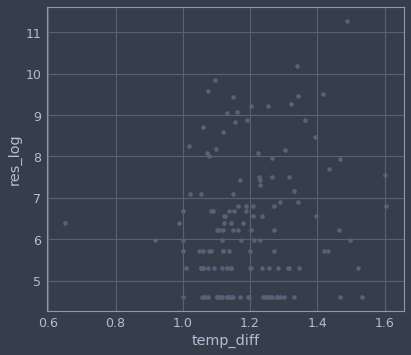

In [210]:
df_tmp['temp_diff'] = df_tmp.tempvoor / df_tmp.tempna
df_tmp['res_log'] = np.log(df_tmp.resultaat)
df_tmp.plot.scatter('temp_diff', 'res_log')